Comparing Rainfall : Seattle, WA V.S Vancouver, BC

#Import libraries



In [397]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns



In [386]:
#load data 
seattle_df = pd.read_csv("../data/seattle_rain.csv")
vancouver_df = pd.read_csv("../data/vancouver_rain.csv")


Inspect Data

In [387]:

display(vancouver_df.head(5))
display(vancouver_df.info())

,STATION,NAME,DATE,DAPR,MDPR,PRCP,SNOW,SNWD
0,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-01,NaN,NaN,0.00,0.0,NaN
1,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-02,NaN,NaN,0.00,0.0,NaN
2,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-03,NaN,NaN,0.00,0.0,NaN
3,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-04,NaN,NaN,0.00,0.0,NaN
4,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-05,NaN,NaN,0.06,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1531 entries, 0 to 1530
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  1531 non-null   object 
 1   NAME     1531 non-null   object 
 2   DATE     1531 non-null   object 
 3   DAPR     30 non-null     float64
 4   MDPR     30 non-null     float64
 5   PRCP     1501 non-null   float64
 6   SNOW     701 non-null    float64
 7   SNWD     26 non-null     float64
dtypes: float64(5), object(3)
memory usage: 95.8+ KB


None

Rename Column   

In [388]:
seattle_df.rename(columns={'PRCP':'seattle_precipitation', 'DATE' : 'date'}, inplace= True)
vancouver_df.rename(columns={'PRCP':'vancouver_precipitation','DATE': 'date'}, inplace= True)


vancouver_df.head(3)

,STATION,NAME,date,DAPR,MDPR,vancouver_precipitation,SNOW,SNWD
0,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-01,NaN,NaN,0.0,0.0,NaN
1,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-02,NaN,NaN,0.0,0.0,NaN
2,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-03,NaN,NaN,0.0,0.0,NaN


Convert Date

In [389]:
seattle_df['date'] = pd.to_datetime(seattle_df['date'])
vancouver_df['date'] = pd.to_datetime(vancouver_df['date'])



display(vancouver_df.head(5))

/var/folders/wx/0m6_v4n9285892l822ksy8740000gn/T/ipykernel_22299/1866814333.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  seattle_df['date'] = pd.to_datetime(seattle_df['date'])


,STATION,NAME,date,DAPR,MDPR,vancouver_precipitation,SNOW,SNWD
0,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-01,NaN,NaN,0.00,0.0,NaN
1,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-02,NaN,NaN,0.00,0.0,NaN
2,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-03,NaN,NaN,0.00,0.0,NaN
3,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-04,NaN,NaN,0.00,0.0,NaN
4,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-05,NaN,NaN,0.06,NaN,NaN


Replace NAN value to Zero and Remove Duplicate

In [390]:

vancouver_df = vancouver_df.fillna(0)
seattle_df = seattle_df.fillna(0)


# Remove duplicate rows if any
seattle_df = seattle_df.drop_duplicates()
vancouver_df = vancouver_df.drop_duplicates()

# Filter datasets to only include dates between 2018-01-01 and 2022-12-31
start_date = '2018-01-01'
end_date = '2022-12-31'

seattle_df = seattle_df[(seattle_df['date'] >= start_date) & (seattle_df['date'] <= end_date)]
vancouver_df = vancouver_df[(vancouver_df['date'] >= start_date) & (vancouver_df['date'] <= end_date)]


display(vancouver_df.head())
display(seattle_df.info())



,STATION,NAME,date,DAPR,MDPR,vancouver_precipitation,SNOW,SNWD
0,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-01,0.0,0.0,0.00,0.0,0.0
1,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-02,0.0,0.0,0.00,0.0,0.0
2,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-03,0.0,0.0,0.00,0.0,0.0
3,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-04,0.0,0.0,0.00,0.0,0.0
4,CA1BC000039,"VANCOUVER 3.4 SSW, BC CA",2018-01-05,0.0,0.0,0.06,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1658 entries, 0 to 1657
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   STATION                1658 non-null   object        
 1   NAME                   1658 non-null   object        
 2   date                   1658 non-null   datetime64[ns]
 3   DAPR                   1658 non-null   float64       
 4   MDPR                   1658 non-null   float64       
 5   seattle_precipitation  1658 non-null   float64       
 6   SNOW                   1658 non-null   float64       
 7   SNWD                   1658 non-null   float64       
 8   WESD                   1658 non-null   float64       
 9   WESF                   1658 non-null   float64       
dtypes: datetime64[ns](1), float64(7), object(2)
memory usage: 129.7+ KB


None

Select Only Date and Precipitation

In [391]:
seattle_df = seattle_df[['date', 'seattle_precipitation']]
vancouver_df = vancouver_df[['date', 'vancouver_precipitation']]

Merge Datasets on date

In [392]:
combine_city = pd.merge(seattle_df, vancouver_df, on = 'date')

#rename column 
combine_city.rename(columns={'precipition_x':'seattle_precipitation','precipition_y':'vancouver_precipitation'})

combine_city.head(5)



,date,seattle_precipitation,vancouver_precipitation
0,2018-01-01,0.00,0.00
1,2018-01-02,0.00,0.00
2,2018-01-03,0.00,0.00
3,2018-01-04,0.00,0.00
4,2018-01-05,0.25,0.06


In [393]:
# Ensure that the data frame is in a tidy, or long, format.

tidy_df = combine_city.melt(id_vars='date', 
                            value_vars=['seattle_precipitation', 'vancouver_precipitation'],
                            var_name='city', 
                            value_name='precipitation')

# Clean up city names
tidy_df['city'] = tidy_df['city'].replace({
    'seattle_precipitation': 'Seattle',
    'vancouver_precipitation': 'Vancouver'
})


* Count rainy days per month

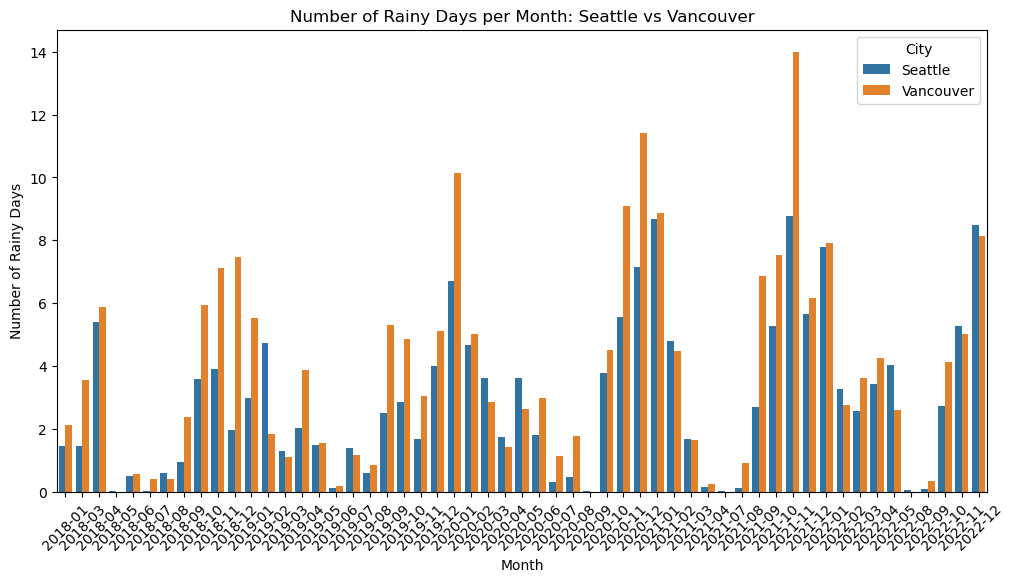

In [394]:
tidy_df['is_rain'] = tidy_df['precipitation'].apply(lambda x: 1 if x > 0 else 0)

tidy_df['month'] = tidy_df['date'].dt.to_period('M')  # create month column
monthly_rain = tidy_df.groupby(['city', 'month'])['precipitation'].sum().reset_index()
monthly_rain.rename(columns={'precipitation':'monthly_total'}, inplace=True)


monthly_rain.head(12)

plt.figure(figsize=(12,6))
sns.barplot(data=monthly_rain, x='month', y='monthly_total', hue='city')

plt.xticks(rotation=45)
plt.title('Number of Rainy Days per Month: Seattle vs Vancouver')
plt.xlabel('Month')
plt.ylabel('Number of Rainy Days')
plt.legend(title='City')
plt.show()


* Vancouver generally has more rainy days than Seattle, especially in the late fall and winter (October–March).

* Seattle’s highest rainy month is December 2022, while Vancouver peaks in October 2021.

Using lineplot to compare by month

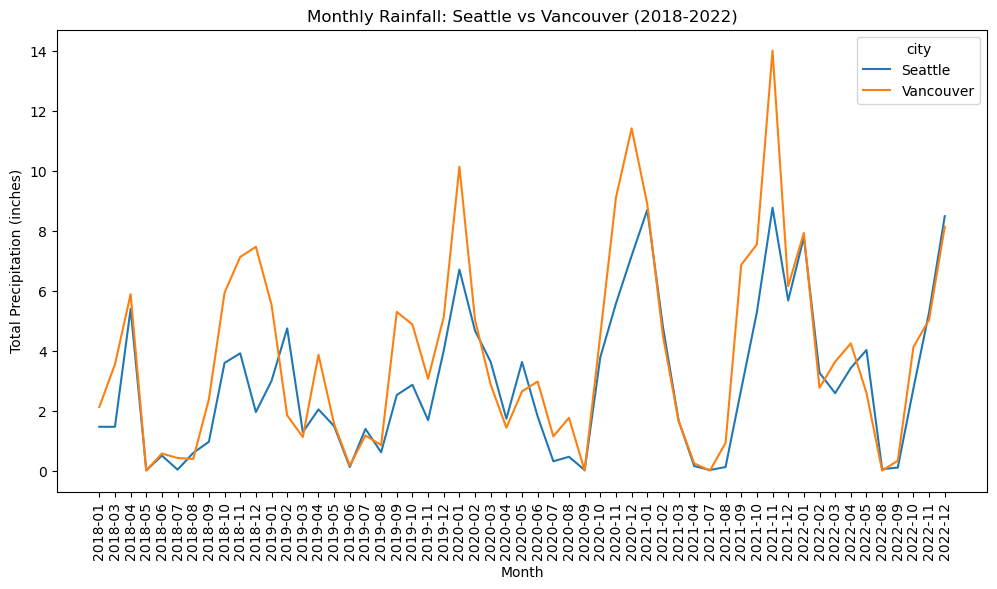

In [395]:
#Create new column month
tidy_df['date'] = pd.to_datetime(tidy_df['date'])

tidy_df['month'] = tidy_df['date'].dt.to_period('M')

# Group by city, month and calculate total rainfall
monthly_rainfall = tidy_df.groupby(['city', 'month'])['precipitation'].sum().reset_index()

monthly_rainfall['month'] = monthly_rainfall['month'].astype(str)


monthly_rainfall.head(6)

plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_rainfall, x='month', y='precipitation', hue='city')

plt.title('Monthly Rainfall: Seattle vs Vancouver (2018-2022)')
plt.xlabel('Month')
plt.ylabel('Total Precipitation (inches)')
plt.xticks(rotation=90)
plt.show()

* Largest difference: October 2021 showed the biggest gap, with Vancouver much wetter than Seattle.

* Both cities have peaks in late fall/winter (Oct–Feb) and lows in summer (Jun–Aug).

Using barplot to analysis data compare by years

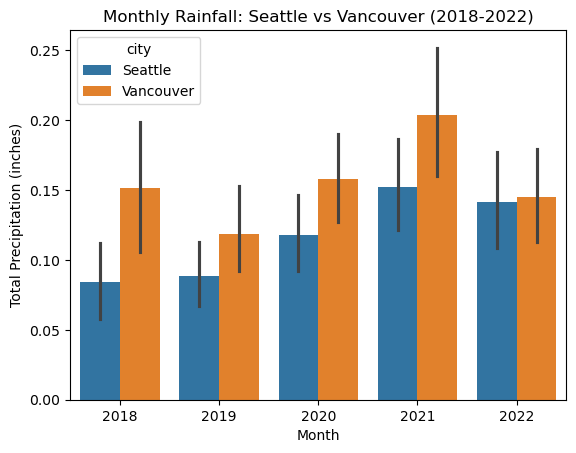

In [396]:
#Create new column years
tidy_df['years'] = tidy_df['date'].dt.year

# Group by month and calculate total rainfall
monthly_rainfall = tidy_df.groupby(['city','years'])[['precipitation']].sum().reset_index()

monthly_rainfall['years'] = monthly_rainfall['years'].astype(str)

sns.barplot(data=tidy_df,x='years', y='precipitation', hue='city')

plt.title('Monthly Rainfall: Seattle vs Vancouver (2018-2022)')
plt.xlabel('Month')
plt.ylabel('Total Precipitation (inches)')
plt.show()

* Over 5 years Vancouver has the highest rain and Vancouver typically adds 10-15 inches more rain than seattle each year.
* Both cities saw a sharp increase from 2019 to 2020.